In [1]:
import torch
import math
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
from muutils.dictmagic import condense_tensor_dict

In [2]:
def normalize(R):
    with torch.no_grad():
        mean = R.mean(dim=0)
        R = R - mean
        norms = torch.norm(R, p=2, dim=1, keepdim=True)
        R = R/norms
    return R

def cal_cov(R):
    with torch.no_grad():
        Z = torch.nn.functional.normalize(R, dim=1)
        A = torch.matmul(Z.T, Z)/Z.shape[0]
    return A

def cal_entropy(A):
    with torch.no_grad():
        eig_val = torch.svd(A / torch.trace(A))[1] 
        entropy = - (eig_val * torch.log(eig_val)).nansum().item()
        normalized_entropy = entropy/math.log(A.shape[0])
    return normalized_entropy


generate 10 stories each for good and bad stories and test on different models with uncertainty
similiarly also do with condensed version of good and bad stories 
normalize according to the prompt lengths


In [19]:
prompt1 = "The Three Little Pigs is a beloved folk tale that tells the story of three pigs, each building a house out of different materials: straw, sticks, and bricks. The youngest pig opts for straw, the middle pig chooses sticks, while the eldest builds his house out of bricks. When a big bad wolf comes to eat them, he easily destroys the first two houses by huffing and puffing, devouring the first two pigs. However, the third pig's brick house withstands the wolf's attempts. Frustrated, the wolf tries to enter through the chimney, but the clever pig boils a pot of water just in time, ending the wolf's threat once and for all. This classic tale highlights the virtues of hard work and resourcefulness, as the most diligent and smartest pig not only survives but thrives."
prompt2 = "In the gloomy depths of a forsaken city, plagued by perpetual storms and decay, a series of calamities unfolded one after another, casting a shadow of despair across the broken streets. Buildings crumbled under the relentless rain, streets flooded, trapping residents in their homes as cries for help echoed through the night. A mysterious illness swept through the population, its origins unknown, causing widespread panic and chaos. Amidst the pandemonium, crime soared as desperate survivors looted abandoned homes and fought over scarce resources. The city, once bustling with life, turned into a dystopian nightmare where hope dwindled with each passing day, and the darkness seemed to swallow everything in its path."


condense_prompt1 = "The Three Little Pigs is a folk tale about three pigs building houses of straw, sticks, and bricks. A wolf destroys the first two houses and eats the pigs, but fails to break the third pig's brick house. Thwarted, the wolf's final attempt through the chimney ends disastrously, illustrating the rewards of hard work and ingenuity."
condense_prompt2 = "In a forsaken city hit by continuous storms and decay, calamities struck relentlessly. Buildings fell, streets flooded, and a mysterious illness caused chaos and panic. Crime surged as survivors looted and fought over dwindling resources, turning the once vibrant city into a dark, dystopian nightmare where hope faded daily."

MODEL1: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-3M")
MODEL2: HookedTransformer = HookedTransformer.from_pretrained("gpt2")




Loaded pretrained model tiny-stories-3M into HookedTransformer
Loaded pretrained model gpt2 into HookedTransformer


In [9]:
def entropy_cal_fn(prompt,MODEL,layer_num): 
    TOKENIZER = MODEL.tokenizer
    input_ids = TOKENIZER.encode(prompt)
    logits, cache = MODEL.run_with_cache(
        prompt,
    )

    layers = []
    firstLayer = "blocks.0.hook_resid_post"

    for i in range(layer_num):
        new_string = firstLayer.replace("0", str(i))
        layers.append(new_string)

    Entropy = []

    for i in range(layer_num):
        with torch.no_grad():
            R = cache[layers[i]][0]
            R = normalize(R)
            A = cal_cov(R)
            Entropy.append(cal_entropy(A))

    return Entropy

In [17]:
Entropy_Tiny_1 = entropy_cal_fn(prompt1,MODEL1,8)
Entropy_Tiny_2 = entropy_cal_fn(prompt2,MODEL1,8)

Entropy_GPT_1 = entropy_cal_fn(prompt1,MODEL2,12)
Entropy_GPT_2 = entropy_cal_fn(prompt2,MODEL2,12)

In [20]:
Entropy_Tiny_1_cond = entropy_cal_fn(condense_prompt1,MODEL1,8)
Entropy_Tiny_2_cond = entropy_cal_fn(condense_prompt2,MODEL1,8)

Entropy_GPT_1_cond = entropy_cal_fn(condense_prompt1,MODEL2,12)
Entropy_GPT_2_cond = entropy_cal_fn(condense_prompt2,MODEL2,12)

In [133]:
d_model: int = MODEL.cfg.d_model
n_layers: int = MODEL.cfg.n_layers
n_heads: int = MODEL.cfg.n_heads
d_vocab: int = MODEL.cfg.d_vocab
print(f"{d_model=}, {n_layers=}, {n_heads=}, {d_vocab=}")

print(input_ids)
print(MODEL(torch.tensor(input_ids)).shape)
print(MODEL(prompt).shape)
print(condense_tensor_dict(cache, return_format="yaml"))

d_model=768, n_layers=12, n_heads=12, d_vocab=50257
[464, 7683, 7703, 49210, 318, 257, 14142, 15504, 12838, 326, 4952, 262, 1621, 286, 1115, 22333, 11, 1123, 2615, 257, 2156, 503, 286, 1180, 5696, 25, 14787, 11, 16461, 11, 290, 28902, 13, 383, 18887, 12967, 2172, 82, 329, 14787, 11, 262, 3504, 12967, 19769, 16461, 11, 981, 262, 34331, 12188, 465, 2156, 503, 286, 28902, 13, 1649, 257, 1263, 2089, 17481, 2058, 284, 4483, 606, 11, 339, 3538, 27838, 262, 717, 734, 7777, 416, 289, 1648, 278, 290, 33679, 278, 11, 1614, 21823, 262, 717, 734, 22333, 13, 2102, 11, 262, 2368, 12967, 338, 17214, 2156, 25073, 82, 262, 17481, 338, 6370, 13, 1305, 436, 4111, 11, 262, 17481, 8404, 284, 3802, 832, 262, 18205, 1681, 11, 475, 262, 14169, 12967, 40169, 257, 1787, 286, 1660, 655, 287, 640, 11, 7464, 262, 17481, 338, 2372, 1752, 290, 329, 477, 13, 770, 6833, 12838, 11330, 262, 27494, 286, 1327, 670, 290, 8271, 15538, 11, 355, 262, 749, 47334, 290, 44730, 12967, 407, 691, 36417, 475, 19531, 1158, 13]
torch.

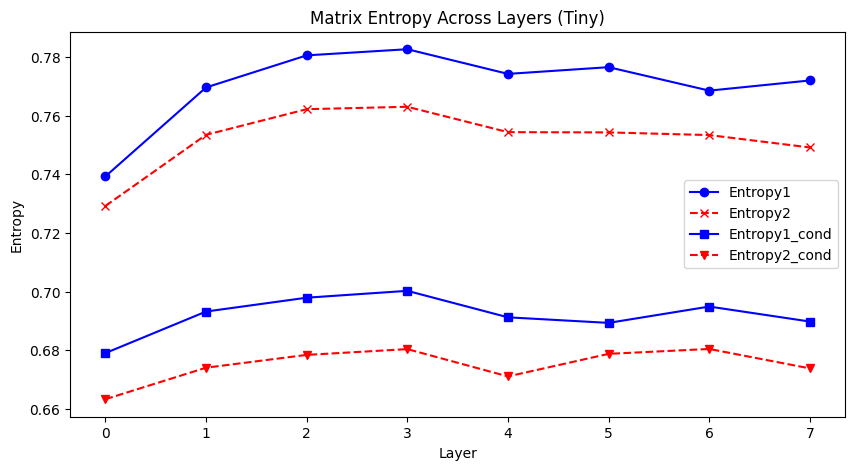

In [26]:
x_values = list(range(len(Entropy_Tiny_1)))

plt.figure(figsize=(10, 5))
plt.plot(x_values, Entropy_Tiny_1, marker='o', linestyle='-', color='b', label='Entropy1')  
plt.plot(x_values, Entropy_Tiny_2, marker='x', linestyle='--', color='r', label='Entropy2') 
plt.plot(x_values, Entropy_Tiny_1_cond, marker='s', linestyle='-', color='b', label='Entropy1_cond')  
plt.plot(x_values, Entropy_Tiny_2_cond, marker='v', linestyle='--', color='r', label='Entropy2_cond')  

plt.legend()
plt.title('Matrix Entropy Across Layers (Tiny)')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(False) 
plt.xticks(x_values) 
plt.show()

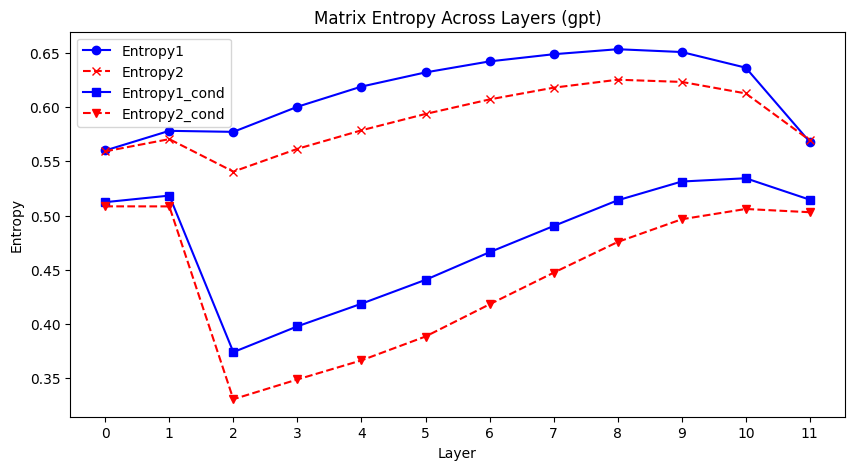

In [28]:
x_values = list(range(len(Entropy_GPT_1)))

plt.figure(figsize=(10, 5))
plt.plot(x_values, Entropy_GPT_1, marker='o', linestyle='-', color='b', label='Entropy1')  
plt.plot(x_values, Entropy_GPT_2, marker='x', linestyle='--', color='r', label='Entropy2') 
plt.plot(x_values, Entropy_GPT_1_cond, marker='s', linestyle='-', color='b', label='Entropy1_cond')  
plt.plot(x_values, Entropy_GPT_2_cond, marker='v', linestyle='--', color='r', label='Entropy2_cond')  

plt.legend()
plt.title('Matrix Entropy Across Layers (gpt)')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(False) 
plt.xticks(x_values) 
plt.show()